# Setup

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
import nltk
from nltk.corpus import stopwords
# from nltk.stem import French
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer # package for french lemmatization
from nltk.tokenize.treebank import TreebankWordDetokenizer
import random
import re
!pip install langdetect
from nltk.corpus import wordnet
from langdetect import detect
!pip install tqdm
from tqdm import tqdm
# from english_dictionary.scripts.read_pickle import get_dict
from english_words import get_english_words_set

seed = 10
random.seed(seed)
np.random.seed(seed)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to c:\users\samue\appdata\local\temp\pip-req-build-jk1q7k0q
  Resolved https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to commit bc0ebd0135a6cc78f48ddf184069b4c0b9c017d8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git 'C:\Users\samue\AppData\Local\Temp\pip-req-build-jk1q7k0q'


## Get Data

In [4]:
#path = '/content/drive/MyDrive/Olympus in the Sky/McGill/2024 - Winter/ECSE 551/Data/'
path = 'Data/'
df = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-15")
df = df.sample(frac=1, random_state=1).reset_index(drop = True)
df = df[~df['body'].str.contains('\?'*10)]

training_data = df['body'].apply(lambda x: x.lower().replace('_', ' ')).to_numpy()
training_labels = df['subreddit'].to_numpy()

## Preprocessing

In [63]:
def get_wordnet_pos(word):
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def remove_stop_words(arr_of_words, stop_words):
  return [word for word in arr_of_words if word not in stop_words]


def remove_invalid_words(text, valid_words):
    return [word for word in text if word in valid_words]

def lemmatize(arr_of_words):
  lang = detect(' '.join(arr_of_words))
  if lang == 'fr':
      # arr_of_words.append('french')
      lemmatizer = FrenchLefffLemmatizer()
      
  else:
      # arr_of_words.append('english')
      lemmatizer = WordNetLemmatizer()

  return [lemmatizer.lemmatize(word) for word in arr_of_words]

def preprocess(sentences, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = None, is_lemmatize = False):
  new_sentence_list = []
  pattern = regex_pattern

  for iter, sentence in enumerate(sentences):

      words = list(set(re.findall(pattern, sentence)))
      if stop_words:
        words = remove_stop_words(words, stop_words)

      if is_lemmatize:
        words = lemmatize(words)

      # if validate_words: 
      #    words = remove_invalid_words(words, validate_words)

      new_sentence_list.append(' '.join(words))

  return np.array(new_sentence_list)

pre-processing without rege

In [224]:
# import string

# def equalize(labels, invalids):
#     good_labels = []
#     for index, label in enumerate(labels): 
#          if index not in invalids:
#                 good_labels.append(label)
#     return np.array(good_labels)

# def preprocess(sentences, labels, stop_words, validate_words):
#   new_sentence_list = []
#   invalid_indices = []
#   for enum, sentence in enumerate(sentences):
#     # remove punctuation
#     # punctuated = "".join([w.lower() for w in sentence if w not in string.punctuation])

#     # remove numbers 
#     sentence_no_num = ''.join(w.lower() for w in sentence if not w.isdigit())
#     # no_nums = ''.joing([w for w in punctuated if not w.isalpha])

#     # tokenize the sentence 
#     tokenized_sentence = nltk.tokenize.word_tokenize(sentence_no_num)

#     # remove stop words
#     valid_sentence = [w.lower() for w in tokenized_sentence if w not in stop_words]

#     full_valid_sentence = [w.lower() for w in valid_sentence if w in validate_words]
#     # cleaned_sentence = [w for w in valid_sentence if w in validate_words]
#     # print(enum, valid_sentence)

#     # lemmatize the sentence
#     # print(full_valid_sentence)
#     # print(i)
#     if full_valid_sentence: 
#       lemmatized_setence  = lemmatize(full_valid_sentence)
#       new_sentence_list.append(' '.join(lemmatized_setence))
#     # valid_sentences = ' '.join([w.lower() for w in sentence if w not in validate_words])
#     else: 
#       invalid_indices.append(enum)
#       # if validate_words: 
#       #    words = remove_invalid_words(words, validate_words)

#     # new_sentence_list.append(' '.join(lemmatized_setence))
#   processed_labels = equalize(labels, invalid_indices)

#   return np.array(new_sentence_list), processed_labels

# Support Vector Machine

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import SGDClassifier
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import svm 

class SVM(): 
    def __init__(self, max_features = 15000, token_pattern = r"(?u)\b[a-z][a-z]+\b", min_df = 1, max_df = 1.0, ngram_range = (1,1), degree = 3, kernel = 'linear', sublinear_tf = False, tol = 1e-3):
        spacy_stopwords_list = list(fr_stop) + list(en_stop)
        nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
        other_stop_words = ['http', 'https', 'www']
        stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))
        self.pattern = token_pattern
        self.ngram_range = ngram_range
        self.degree = degree
        self.kernel = kernel
        self.sublinear_tf = sublinear_tf
        self.tol = tol
        self.vectorizer = TfidfVectorizer(max_features = max_features, lowercase=True, token_pattern= token_pattern, min_df = min_df, max_df = max_df, ngram_range = ngram_range, sublinear_tf=sublinear_tf)
        # self.vectorizer = CountVectorizer(binary = True, max_features = max_features, token_pattern=token_pattern, lowercase=True, strip_accents='unicode', min_df = min_df, max_df = max_df, ngram_range = ngram_range)
        self.svm_class = svm.SVC(C=1,kernel=kernel, random_state=seed, degree=degree, tol=tol)

    def train(self, x_data_train, x_data_labels):
        assert len(x_data_train)  == len(x_data_labels)
        # assert type(x_data_train) == type(x_data_labels) == np.ndarray
        # fit the 
        vectors_train_idf = self.vectorizer.fit_transform(x_data_train)
        self.svm_class.fit(vectors_train_idf, x_data_labels)
    
    def predict(self, x_data_test): 
        tfidf_test = self.vectorizer.transform(x_data_test)
        x_data_pred = self.svm_class.predict(tfidf_test)
        return x_data_pred


X_train = [
    "On est bien d?accord que la question pos‚e ne contenait pas le mot SUV, mais bien les diff‚rents adjectifs, lourds,  encombrant, polluants. Sans ®ÿetÿ¯. Les voitures/camionettes (?), encombrantes ou  polluantes des pauvres (ou pas) seront bien tax‚es comme les 4x4?",
    "You can thank the state governments soft approach on drugs and the injecting rooms for the proliferation of junkies all over the city. To save a few lives of junkies that add zero to society, they've destroyed the city for the rest of us. Let's not pretend that heroin users and ice users are mutually exclusive groups.",
    "I?m not comparing them because I?m not clued up enough on either situation but I would love to understand how we are all so angry about what?s going on in Gaza but we all basically ignored the genocide in sudan? Is it because Sudan was a civil war and Gaza is attacked by a different state?",
    "My group is mid to late 30s. We match our agendas and commit. We're pretty open about how we feel (tiredness, money, other commitments) but mainly we make an effort to show up because we enjoy hanging around each other. As an introvert i found friends who don't drain my energy so that also helps.",
    "I was ready to be disappointed tbh (last years were misses for me) but I?m pleasantly surprised on this one! Arlo Parks, L‚onie Gray, Ren‚e Rapp (loved her on Broadway), Labrinth, T-Pain, Hozier, Jungle (great music fest vibes), Still Woozy, Raye?this is gonna be fun! Unsure if it?s 395$ fun though ??"]

y_train = ["Paris", "Melbourne", "London", "London", "Montreal"]  # 1 for positive sentiment, 0 for negative sentiment

model = SVM()
model.train(X_train, y_train)

X_test = [
    "Dosa Pointe - If you can get it ! Often sells out and quickly Restaurant Canada Best - absolutely incredible, don't believe me look up the reviews Halal 786 - even just the plain Biryani rice is delicious beyond so many other things on the menu, have it weekly",  
    "# Upvote/Downvote reminder Like this image or appreciate it being posted? Upvote it and show it some love! Don't like it? Just downvote and move on. *Upvoting or downvoting images it the best way to control what you see on your feed and what gets to the top of the subreddit* *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/london) if you have any questions or concerns.*",
    "Les jardins du chateau de versailles. C'est pas une nature sauvage, mais vu la dimension des jardins, tu peux te retrouver dans des endroits o— aucun touriste n'osera s'aventurer. 15 minutes de train + 10 minutes de marche depuis la gare montparnasse. Id‚alement, avec un v‚lo..."]

Y_test = ["Montreal", "London", "Paris"]


y_pred = model.predict(X_test)
print(y_pred)

print("Accuracy:",accuracy_score(Y_test, y_pred))


        

['London' 'London' 'Paris']
Accuracy: 0.6666666666666666


K fold for SVM: 

In [7]:
def k_fold_validation(x_train_data, y_train_data, K = 10, max_features = 3000, degree = 3, kernel = 'linear', sublinear_tf = False, tol = 1e-3):
  assert type(x_train_data) == np.ndarray and type(y_train_data) == np.ndarray

  len_of_data  = len(x_train_data) - len(x_train_data) % K
  data_x       = x_train_data[:len_of_data]
  data_y       = y_train_data[:len_of_data]
  size_of_fold = len(x_train_data[:len_of_data]) // K
  validation_error = 0
  labels = ["Paris", "London", "Melbourne", "Montreal"]


  error    = []
  pred     = []
  timings  = []
  cm = np.zeros((len(labels), len(labels)))
  cm_s = []
  # no_preds = []

  # naive_bayes = NB()

  for i in range(K):

    support_vector = SVM(degree=degree, kernel=kernel, max_features=max_features, sublinear_tf=sublinear_tf, tol=tol)

    if i != K-1:
      validation_fold_x = data_x[i*size_of_fold:(i+1)*size_of_fold]
      validation_fold_y = data_y[i*size_of_fold:(i+1)*size_of_fold]

      training_folds_x  = np.concatenate((data_x[:i*size_of_fold], data_x[(i+1)*size_of_fold:]))
      training_folds_y  = np.concatenate((data_y[:i*size_of_fold], data_y[(i+1)*size_of_fold:]))

    else:
      validation_fold_x = data_x[i*size_of_fold:]
      validation_fold_y = data_y[i*size_of_fold:]

      training_folds_x  = data_x[:i*size_of_fold]
      training_folds_y  = data_y[:i*size_of_fold]

    start_time = time.time()
    support_vector.train(training_folds_x, training_folds_y)
    end_time = time.time()

    timings.append(end_time - start_time)

    pred_valid = support_vector.predict(validation_fold_x)
    confusion = confusion_matrix(validation_fold_y, pred_valid)
    cm = np.add(cm, confusion)
    # no_pred = naive_bayes.no_pred
    # pred_train = naive_bayes.predict(training_folds_x)

    fold_error = {}
    fold_error['validation'] = 1 - accuracy_score(pred_valid, validation_fold_y)
    validation_error        += 1 - accuracy_score(pred_valid, validation_fold_y)
    # fold_error['train']      = 1 - accuracy_score(pred_train, training_folds_y)

    model_pred = {}
    model_pred['validation'] = (pred_valid, validation_fold_y)
    # model_pred['train']      = (pred_train, training_folds_y )

    error.append(fold_error)
    pred.append(model_pred)
    cm_s.append(confusion)
    # no_preds.append(no_pred)

  info = {'error': error, 'pred': pred, 'time': timings, 'confusion_matrices':cm_s, 'average confusion matrix': cm/K}

  return validation_error/K, info

In [41]:
# No preprocessing

test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(training_data, training_labels,  test_size = int(len(training_data)*test_split), random_state=seed)

model = SVM()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print(pred)
print("Accuracy:",accuracy_score(testing_labels_split, pred))


# mean_error, info = k_fold_validation(training_data_split, training_labels_split)
# print('Mean Error: {}'.format(mean_error))

['Melbourne' 'Paris' 'Paris' 'Montreal' 'Melbourne' 'Melbourne' 'London'
 'London' 'Melbourne' 'Melbourne' 'London' 'Melbourne' 'Montreal'
 'Melbourne' 'Paris' 'Montreal' 'Melbourne' 'Melbourne' 'London'
 'Montreal' 'Montreal' 'Montreal' 'Montreal' 'London' 'Melbourne'
 'Montreal' 'London' 'Montreal' 'Melbourne' 'Montreal' 'Melbourne'
 'Montreal' 'Melbourne' 'London' 'Melbourne' 'Paris' 'Melbourne' 'Paris'
 'Paris' 'Melbourne' 'Paris' 'Paris' 'Melbourne' 'Melbourne' 'Melbourne'
 'Montreal' 'Melbourne' 'London' 'Melbourne' 'Melbourne' 'London'
 'Melbourne' 'Melbourne' 'Melbourne' 'Melbourne' 'Paris' 'London' 'London'
 'Melbourne' 'Melbourne' 'Melbourne' 'London' 'Paris' 'Montreal'
 'Melbourne' 'Montreal' 'Montreal' 'London' 'London' 'Melbourne'
 'Melbourne' 'Montreal' 'Paris' 'Melbourne' 'Montreal' 'Melbourne'
 'London' 'Melbourne' 'Melbourne' 'Paris' 'Melbourne' 'Paris' 'Melbourne'
 'Montreal' 'Paris' 'Melbourne' 'Melbourne' 'Melbourne' 'Montreal' 'Paris'
 'Melbourne' 'London' 'Montrea

SVM Experiments

In [9]:
df = pd.read_csv(path + 'dictionnaire.txt', encoding= "ISO-8859-15")
mots = df.iloc[:,0].to_list()
nltk.download('words')
english_words = nltk.corpus.words.words()

english_words.extend(mots)

test_split = 0.1

spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
other_stop_words = ['http', 'https', 'www']
stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

# df = pd.DataFrame(english_words)
# df.to_csv('dictionnary.csv')



[nltk_data] Downloading package words to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [10]:
# No preprocessing using countVectorizer 
test_split = 0.2
processed_training_data = preprocess(sentences=training_data,stop_words=stop_words, is_lemmatize=True)
(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, training_labels, test_size = int(len(training_data)*test_split), random_state=seed)


In [11]:
test_df = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
test_data = test_df['body'].to_numpy()
processed_test_data = preprocess(sentences=test_data,stop_words=stop_words, is_lemmatize=True)

# model = SVM()


In [10]:
model = SVM()
model.train(training_data_split, training_labels_split)
pred = model.predict(processed_test_data)
print(pred)
print("Accuracy:",accuracy_score(testing_labels_split, pred))

['Melbourne' 'Paris' 'Paris' 'Montreal' 'Melbourne' 'Melbourne'
 'Melbourne' 'London' 'Melbourne' 'Melbourne' 'Melbourne' 'London'
 'Montreal' 'Melbourne' 'Paris' 'Montreal' 'London' 'London' 'London'
 'Montreal' 'Montreal' 'Paris' 'Melbourne' 'London' 'Melbourne' 'Montreal'
 'London' 'Montreal' 'Melbourne' 'Montreal' 'Paris' 'Montreal' 'Melbourne'
 'London' 'London' 'Paris' 'Melbourne' 'Paris' 'Paris' 'Melbourne'
 'Montreal' 'Paris' 'Paris' 'Melbourne' 'Montreal' 'Montreal' 'Melbourne'
 'London' 'Montreal' 'Montreal' 'London' 'Melbourne' 'London' 'Melbourne'
 'London' 'Paris' 'London' 'London' 'Melbourne' 'Melbourne' 'Melbourne'
 'Montreal' 'Paris' 'Montreal' 'Melbourne' 'Montreal' 'Montreal' 'London'
 'London' 'Melbourne' 'London' 'Montreal' 'Paris' 'Melbourne' 'Montreal'
 'Montreal' 'London' 'Melbourne' 'Melbourne' 'Paris' 'Melbourne' 'Paris'
 'Melbourne' 'Montreal' 'Paris' 'Melbourne' 'Melbourne' 'Melbourne'
 'London' 'Paris' 'Melbourne' 'London' 'Montreal' 'Paris' 'Montreal'
 'Par

In [285]:
model = SVM(max_features=3000, degree=2, kernel='poly')
model.train(training_data_split, training_labels_split)
pred = model.predict(processed_test_data)
print(pred)
print("Accuracy:",accuracy_score(testing_labels_split, pred))

['Melbourne' 'Paris' 'Paris' 'Montreal' 'Melbourne' 'Melbourne'
 'Melbourne' 'London' 'Melbourne' 'Melbourne' 'Melbourne' 'London'
 'Montreal' 'Melbourne' 'Paris' 'Montreal' 'London' 'Melbourne' 'London'
 'Montreal' 'Montreal' 'Paris' 'Melbourne' 'London' 'Melbourne' 'Montreal'
 'London' 'Melbourne' 'Melbourne' 'Montreal' 'Paris' 'Montreal'
 'Melbourne' 'London' 'Montreal' 'Paris' 'Melbourne' 'Paris' 'Paris'
 'Melbourne' 'Montreal' 'Paris' 'Melbourne' 'Melbourne' 'Montreal'
 'Montreal' 'Melbourne' 'London' 'Montreal' 'Montreal' 'Montreal'
 'Melbourne' 'Montreal' 'Melbourne' 'Melbourne' 'Paris' 'London' 'London'
 'Melbourne' 'Melbourne' 'Melbourne' 'Montreal' 'London' 'Montreal'
 'Melbourne' 'Montreal' 'Montreal' 'Montreal' 'London' 'Melbourne'
 'Melbourne' 'Paris' 'Paris' 'Melbourne' 'Montreal' 'Montreal' 'London'
 'Melbourne' 'Melbourne' 'Paris' 'Montreal' 'Paris' 'Melbourne' 'Montreal'
 'Paris' 'London' 'Melbourne' 'Melbourne' 'London' 'Paris' 'Melbourne'
 'London' 'Montreal' 'Paris'

K fold experiment

In [40]:
test_df = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
test_data = test_df['body'].to_numpy()

max_feature_list = [3000, 5000, 9000, 10000, 12000, 15000]
kernel_type = ['linear', 'poly', 'sigmoid']
degrees = [1, 2, 3]
tol = [1e-2, 1e-3, 1e-4, 1e-5]

labels = ["Paris", "London", "Melbourne", "Montreal"]

hps = []
for features in max_feature_list:
    for kernel in kernel_type:
        for tolerance in tol:
            for degree in degrees:
                hps.append((features, kernel, tolerance, degree))

errors = []
infos = []
for features, kernel, tolerance, degree in hps:
    mean_error, info = k_fold_validation(training_data_split, training_labels_split, max_features = features, degree = degree, kernel = kernel, tol=tolerance)
    errors.append((mean_error, features, kernel, tolerance, degree))
    infos.append(info)

min = 1
index = -1

for i, error in enumerate(errors):
    if error[0] is not None and error[0] < min:
        index = i
        min = error[0]

if index != -1: 
    features, kernel, tolerance, degree = hps[index]

    model = SVM(max_features=features, kernel=kernel, degree=degree, tol=tolerance)

    model.train(processed_training_data, training_labels)

    pred = model.predict(test_data)
    prediction = model.predict(processed_test_data)
    # print(errors[index][0])
    print('best Hps: {}'.format(hps[index]))
    pd.DataFrame({'Subreddit':pred}).reset_index().rename(columns={"index": "Id"}).to_csv(path + 'hp_optimization/' + 'results_SVM_2_0.2.csv', index=False)
    pd.DataFrame({'Subreddit':prediction}).reset_index().rename(columns={"index": "Id"}).to_csv(path + 'hp_optimization/' + 'results_SVM_processed_2_0.2.csv', index=False)
    disp = ConfusionMatrixDisplay(confusion_matrix=infos[index]['average confusion matrix'], display_labels=labels)
    disp.plot()
    plt.show()
    # plt.savefig(path + 'hp_optimization/' + 'SVM_' + str(hps[index][0])+ '_' + hps[index][1] + '_' + str(hps[index][2]) + '_' + str(hps[index][3]) + 'confusion matrix.png')
else: 
    print("No hyperparameters were viable")


df = pd.DataFrame(errors)
df2 = pd.DataFrame(infos)

df.to_csv(path + 'hp_optimization/' + 'Mean errors_2_0.2.csv')
df2.to_csv(path + 'hp_optimization/' + 'infos_2_0.2.csv')

KeyboardInterrupt: 

In [60]:
from sklearn.metrics import classification_report

Accuracy: 0.6845878136200717


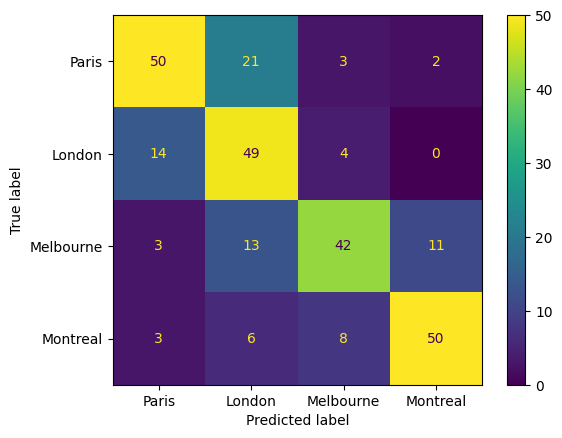

In [69]:
model2 = SVM(max_features=9000, degree=1, kernel='linear', tol=0.1, sublinear_tf=False)
model2.train(training_data_split, training_labels_split)
pred = model2.predict(testing_data_split)
print("Accuracy:",accuracy_score(testing_labels_split, pred))
cm = confusion_matrix(testing_labels_split, pred)
df = pd.DataFrame.from_dict(classification_report(testing_labels_split, pred,output_dict=True))
df.to_csv("Classification Metrics SVM.csv")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()


Accuracy: 0.6559139784946236


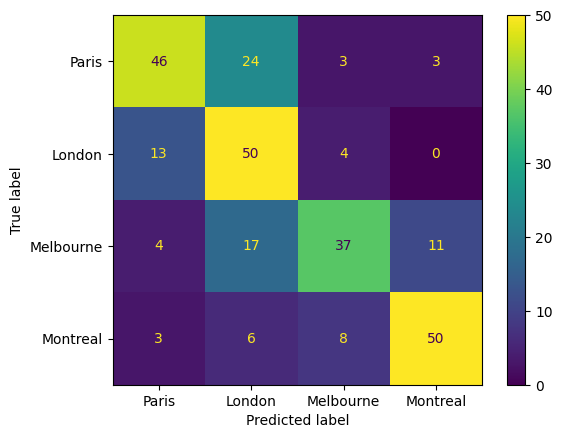

In [70]:
from sklearn.linear_model import LogisticRegression
# processed_training_data = preprocess(training_data, stop_words = stop_words)

model = LogisticRegression()

vectorizer = TfidfVectorizer(token_pattern = r"(?u)\b[a-z][a-z]+\b", max_df = 0.5, max_features = 4000, min_df= 1)

model.fit(vectorizer.fit_transform(training_data_split), training_labels_split)

pred = model.predict(vectorizer.transform(testing_data_split))

print("Accuracy:",accuracy_score(testing_labels_split, pred))

cm = confusion_matrix(testing_labels_split, pred)
df = pd.DataFrame.from_dict(classification_report(testing_labels_split, pred,output_dict=True))
df.to_csv("Classification Metrics LR.csv")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

Mean Error: 0.29732142857142857


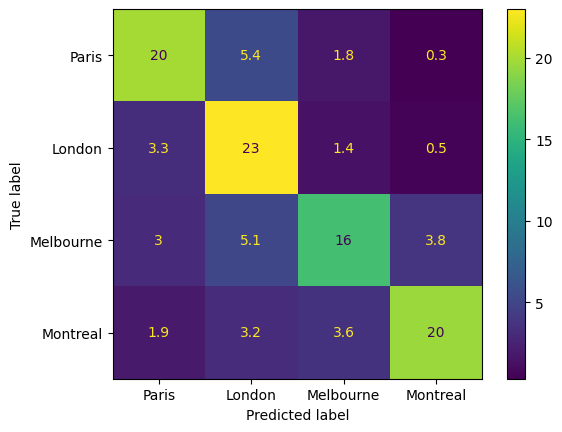

info: [[19.9  5.4  1.8  0.3]
 [ 3.3 23.   1.4  0.5]
 [ 3.   5.1 16.2  3.8]
 [ 1.9  3.2  3.6 19.6]]


In [57]:
# model = SVM(max_features=5000, kernel='linear', degree=1, sublinear_tf=True)
labels = ["Paris", "London", "Melbourne", "Montreal"]
mean_error, info = k_fold_validation(training_data_split, training_labels_split, max_features = 10000, degree = 1, kernel = 'linear', sublinear_tf = True, tol=1e-5)
print('Mean Error: {}'.format(mean_error))
disp = ConfusionMatrixDisplay(confusion_matrix=info['average confusion matrix'], display_labels=labels)
disp.plot()
plt.show()
print('info: {}'.format(info['average confusion matrix']))

# model.train(processed_training_data, training_labels)
# prediction = model.predict(processed_test_data)

# pd.DataFrame({'Subreddit':prediction}).reset_index().rename(columns={"index": "Id"}).to_csv(path + 'hp_optimization/' + 'results_SVM_processed.csv', index=False)


In [143]:
df = pd.read_csv(path + 'dictionnaire.txt', encoding= "ISO-8859-15")
mots = df.iloc[:,0].to_list()
nltk.download('words')
english_words = nltk.corpus.words.words()

english_words.extend(mots)

test_split = 0.2

spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
other_stop_words = ['http', 'https', 'www']
stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

# df = pd.DataFrame(english_words)
# df.to_csv('dictionnary.csv')



[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [185]:
# WithPreprocessing 


# mots = set(line.strip() for line in open(path + 'dictionnaire.txt', encoding= "ISO-8859-15"))
model = SVM()

X_train = [
    "On est bien d?accord que la question pos‚e ne contenait pas le mot SUV, mais bien les diff‚rents adjectifs, lourds,  encombrant, polluants. Sans ®ÿetÿ¯. Les voitures/camionettes (?), encombrantes ou  polluantes des pauvres (ou pas) seront bien tax‚es comme les 4x4?",
    "You can thank the state governments soft approach on drugs and the injecting rooms for the proliferation of junkies all over the city. To save a few lives of junkies that add zero to society, they've destroyed the city for the rest of us. Let's not pretend that heroin users and ice users are mutually exclusive groups.",
    "I?m not comparing them because I?m not clued up enough on either situation but I would love to understand how we are all so angry about what?s going on in Gaza but we all basically ignored the genocide in sudan? Is it because Sudan was a civil war and Gaza is attacked by a different state?",
    "My group is mid to late 30s. We match our agendas and commit. We're pretty open about how we feel (tiredness, money, other commitments) but mainly we make an effort to show up because we enjoy hanging around each other. As an introvert i found friends who don't drain my energy so that also helps.",
    "bghkndofu ?????????????????????????????????????????????????????????????????????????????????",
    "bghkndofu ?????????????????????????????????????????????????????????????????????????????????",
    "I was ready to be disappointed tbh (last years were misses for me) but I?m pleasantly surprised on this one! Arlo Parks, L‚onie Gray, Ren‚e Rapp (loved her on Broadway), Labrinth, T-Pain, Hozier, Jungle (great music fest vibes), Still Woozy, Raye?this is gonna be fun! Unsure if it?s 395$ fun though ??"]

X_labels = np.array(["Paris", "Melbourne", "London", "London", "Montreal", "Paris", "Montreal"])

processed_training_data, processed_labels = preprocess(X_train, X_labels, stop_words, validate_words=english_words)

X_test = [
    "Dosa Pointe - If you can get it ! Often sells out and quickly Restaurant Canada Best - absolutely incredible, don't believe me look up the reviews Halal 786 - even just the plain Biryani rice is delicious beyond so many other things on the menu, have it weekly",  
    "# Upvote/Downvote reminder Like this image or appreciate it being posted? Upvote it and show it some love! Don't like it? Just downvote and move on. *Upvoting or downvoting images it the best way to control what you see on your feed and what gets to the top of the subreddit* *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/london) if you have any questions or concerns.*",
    "Les jardins du chateau de versailles. C'est pas une nature sauvage, mais vu la dimension des jardins, tu peux te retrouver dans des endroits o— aucun touriste n'osera s'aventurer. 15 minutes de train + 10 minutes de marche depuis la gare montparnasse. Id‚alement, avec un v‚lo..."]

Y_test = ["Montreal", "London", "Paris"]

model.train(processed_training_data, processed_labels)

y_pred = model.predict(X_test)
print(y_pred)

print("Accuracy:",accuracy_score(Y_test, y_pred))

# print(processed_training_data)
# print(processed_labels)
# print(procedd_training_labels)

# # df = pd.DataFrame(processed_training_data)

# # df.to_csv("Processed Test.csv")

# (training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, training_labels,  test_size = int(len(training_data)*test_split), random_state=seed)
# # print(training_data_split)
# # model = SVM()
# model.train(training_data_split, training_labels_split)
# pred = model.predict(testing_data_split)
# # # print(pred)
# print("Accuracy:",accuracy_score(testing_labels_split, pred))


['London' 'London' 'London']
Accuracy: 0.3333333333333333


In [197]:

processed_training_data, processed_training_labels = preprocess(training_data, training_labels, stop_words, validate_words=english_words)

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, processed_training_labels, test_size = int(len(training_data)*test_split), random_state=seed)

# model.train(training_data_split, training_labels_split)

# pred = model.predict(testing_data_split)

# print("Accuracy:",accuracy_score(testing_labels_split, pred))



In [202]:
model = SVM()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print("Accuracy:",accuracy_score(testing_labels_split, pred))

# print(training_data_split)
# print(training_labels_split)
# dict = {"Prediction": pred, "True": testing_labels_split}

# df = pd.DataFrame(dict)

# df.to_csv("Output_comp.csv")



Accuracy: 0.5899280575539568


In [93]:
test_df = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
test_data = test_df['body'].to_numpy()

prediction = model.predict(test_data)

# processed_test_data = lemmatize_and_remove_stop_words(test_data)

# predictions = model.predict(processed_test_data)

In [54]:
prediction = model.predict(processed_test)
pd.DataFrame({'Subreddit':prediction}).reset_index().rename(columns={"index": "Id"}).to_csv('results_SVM.csv', index=False)

In [72]:
num_words = [3000, 5000, 7000, 9000, 11000, 13000]
n_grams = []
mean_error, info = k_fold_validation(processed_training_data, training_labels)
print('Mean Error: {}'.format(mean_error))

Mean Error: 0.3064748201438849


# Random Forest

# NB and K-Fold

In [ ]:
# to find P(Y=k), just do test_labels.where(k)/len(test_labels)
# vectos_train will contain all the information I need to create the counting for each word
# use the get_feature_names to create a dictionary to map to all counts
# this dictionary would be contained in another dict that has the labels as keys
# to find P(xj,k), find the indices where test_labels = (k), then find

In [9]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

class LemmaTokenizer:
     def __init__(self, pattern):
       self.pattern = pattern
     def __call__(self, doc):
       doc = doc.lower().replace('_', ' ')
       doc_words = list(set(re.findall(self.pattern, doc)))
       lang = detect(' '.join(doc_words))
       if lang == 'en':
           lemmatizer = WordNetLemmatizer()
       else:
           lemmatizer = FrenchLefffLemmatizer()
       return [lemmatizer.lemmatize(word,pos =get_wordnet_pos(word)) for word in doc_words]

In [8]:
class NB():
  def __init__(self, max_features = 3000, token_pattern = r"(?u)\b[a-z][a-z]+\b", min_df = 1, max_df = 1.0, ngram_range = (1,1)):
    spacy_stopwords_list = list(fr_stop) + list(en_stop)
    nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
    self.pattern = token_pattern
    self.ngram_range = ngram_range
    self.vectorizer = CountVectorizer(binary = True, max_features = max_features, token_pattern = self.pattern, min_df = min_df, max_df = max_df, ngram_range = ngram_range)
    self.no_pred = []

  # currently train_corpus expects a np array containing a list of strings, not array of words, nxm
  # test_label is an nx1 array
  def train(self, train_corpus, test_labels):
    assert len(train_corpus)  == len(test_labels)
    assert type(train_corpus) == type(test_labels) == np.ndarray

    vectors_train       = self.vectorizer.fit_transform(train_corpus).todense()
    self.analyzer       = self.vectorizer.build_analyzer()
    self.word_list      = self.vectorizer.get_feature_names_out()
    self.num_samples    = len(test_labels)
    self.word_count     = dict(zip(self.word_list, np.array(vectors_train.sum(axis=0))[0]))

    unique, counts   = np.unique(test_labels, return_counts=True)
    self.label_count = dict(zip(unique, counts))
    self.labels      = unique

    self.word_count_given_label = {}
    for label in self.labels:
      indices = np.where(test_labels == label)[0]
      tot_word_count = np.array(vectors_train[indices].sum(axis=0))[0]
      self.word_count_given_label[label] = {self.word_list[i] : tot_word_count[i] for i in range(len(tot_word_count))}
      # print(label, self.word_count_given_label[label])

  # Assuming test_corpus is 2-d array where each test sample is a string
  def predict(self, test_corpus):

    predictions = []
    for corpus in tqdm(test_corpus, desc="Loading…", ascii=False, ncols=75):

      best_label = ''
      best_prob  = -np.inf

      corpus_words = self.analyzer(corpus)

      for label in self.labels:
        p_of_y = self.label_count[label]/self.num_samples

        p_of_x_given_y = 1

        for word in self.word_list:
          if word in corpus_words:
            xj = 1
          else:
            xj = 0

          theta_xj_k      = (self.word_count_given_label[label][word] + 1) / (self.label_count[label] + len(self.labels))
          p_of_x_given_y *= (theta_xj_k**(xj) * (1-theta_xj_k)**(1-xj))
          # print(label, word, p_of_x_given_y, theta_xj_k, (theta_xj_k**(xj) * (1-theta_xj_k)**(1-xj)))

        unseen_words = [new_word for new_word in corpus_words if new_word not in self.word_list]
        for word in unseen_words:
          # p_of_x_given_y *= 1/(self.label_count[label] + len(self.labels))
          p_of_x_given_y *= 1/(len(self.labels)) # When there are a large number of unseen words, the p_of_x_given_y basically becomes 0
        # print(len(unseen_words), len(corpus_words))

        p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
        # print(p_of_y, p_of_x_given_y)
        # print(label, p_of_y_given_x)

        # print(p_of_y_given_x, best_prob)
        if p_of_y_given_x > best_prob:
          best_prob = p_of_y_given_x
          best_label = label

      if p_of_x_given_y == 0:
        self.no_pred.append(corpus)
      #   best_label = random.choice(self.labels)

      predictions.append(best_label)

    return predictions

In [10]:
def k_fold_validation(x_train_data, y_train_data, K = 10):
  assert type(x_train_data) == np.ndarray and type(y_train_data) == np.ndarray

  len_of_data  = len(x_train_data) - len(x_train_data) % K
  data_x       = x_train_data[:len_of_data]
  data_y       = y_train_data[:len_of_data]
  size_of_fold = len(x_train_data[:len_of_data]) // K
  validation_error = 0

  error    = []
  pred     = []
  timings  = []
  no_preds = []

  naive_bayes = NB()

  for i in range(K):

    naive_bayes = NB()

    if i != K-1:
      validation_fold_x = data_x[i*size_of_fold:(i+1)*size_of_fold]
      validation_fold_y = data_y[i*size_of_fold:(i+1)*size_of_fold]

      training_folds_x  = np.concatenate((data_x[:i*size_of_fold], data_x[(i+1)*size_of_fold:]))
      training_folds_y  = np.concatenate((data_y[:i*size_of_fold], data_y[(i+1)*size_of_fold:]))

    else:
      validation_fold_x = data_x[i*size_of_fold:]
      validation_fold_y = data_y[i*size_of_fold:]

      training_folds_x  = data_x[:i*size_of_fold]
      training_folds_y  = data_y[:i*size_of_fold]

    start_time = time.time()
    naive_bayes.train(training_folds_x, training_folds_y)
    end_time = time.time()

    timings.append(end_time - start_time)

    pred_valid = naive_bayes.predict(validation_fold_x)
    no_pred = naive_bayes.no_pred
    # pred_train = naive_bayes.predict(training_folds_x)

    fold_error = {}
    fold_error['validation'] = 1 - accuracy_score(pred_valid, validation_fold_y)
    validation_error        += 1 - accuracy_score(pred_valid, validation_fold_y)
    # fold_error['train']      = 1 - accuracy_score(pred_train, training_folds_y)

    model_pred = {}
    model_pred['validation'] = (pred_valid, validation_fold_y)
    # model_pred['train']      = (pred_train, training_folds_y )

    error.append(fold_error)
    pred.append(model_pred)
    no_preds.append(no_pred)

  info = {'error': error, 'pred': pred, 'time': timings, 'no_preds' : no_preds}

  return validation_error/K, info

# Simple test cases for NB

In [81]:
train_corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
     'Is this the first document?',]
test_labels = np.array(['1', '2', '3', '4'])
train_corpus = np.array(train_corpus)
test_corpus = ['harro first pink haha']
model = NB()
model.train(train_corpus, test_labels)
model.predict(test_corpus)

Loading…: 100%|████████████████████████████| 1/1 [00:00<00:00, 1860.83it/s]


['1']

In [84]:
# Training data
X_train = np.array([
    "I love this movie",
    "This movie is great",
    "A movie like this is great",
    "I hate this movie",
    "This movie is terrible"])

# Corresponding labels
y_train = np.array([1, 1, 1, 0, 0])  # 1 for positive sentiment, 0 for negative sentiment

model = NB()
model.train(X_train, y_train)
X_test = [
    "I love this movie terrible", # Example of both class being viable but the second being chosen due to label eval order in NB
    "I hate this great movie",
    "This movie is terrible"]

print(model.predict(X_test))

Loading…: 100%|████████████████████████████| 3/3 [00:00<00:00, 2381.77it/s]

[0, 1, 0]


# K-fold for NB

In [ ]:
# TODO: No predictions given, divide by zero warnings might be the cause (Solved?)
# TODO: Test changing the prob caluclation to be a sum of logs

In [93]:
# No preprocessing
test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(training_data, training_labels,  test_size = int(len(training_data)*test_split), random_state=seed)

model = NB()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print((pred == testing_labels_split).sum()/len(testing_labels_split))
print()
print(model.no_pred)

mean_error, info = k_fold_validation(training_data_split, training_labels_split)
print('Mean Error: {}'.format(mean_error))

Loading…:  27%|███████▍                   | 38/139 [00:04<00:14,  7.16it/s]<ipython-input-80-ccddaf706752>:65: RuntimeWarning: divide by zero encountered in log
  p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
Loading…: 100%|██████████████████████████| 139/139 [00:11<00:00, 11.79it/s]


0.5755395683453237

['in my own experience personal experience (mid 40\'s m gay) i haven\'t seen what you\'ve described often. although unless it\'s blatantly obvious and annoying i\'d very likely be oblivious to it, plus it would be much less likely to be directed at me as a male.  other people\'s experiences particularly that of women may differ significantly, so don\'t think i\'m downplaying sexual harassment or verbal abuse!\n\ni have witnessed behaviour similar to your descriptions at times in the past in public, private and workplace settings.  if people wish to \'perv\' usually they more discreet with any \'casual observations\' rather than openly leering while practically drooling everywhere like an over excited dog \n\n\nbelow are several (hopefully) plausible explanations that may (or may not) assist you:\n\n\n*this list does not cover all possible solutions.  it provides some scenarios with possible outcomes.  all of which is solely relying on my personal experience, knowled

Loading…:  43%|███████████▌               | 54/126 [00:05<00:07,  9.08it/s]<ipython-input-80-ccddaf706752>:65: RuntimeWarning: divide by zero encountered in log
  p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
Loading…:  96%|████████████████████████▉ | 121/126 [00:07<00:00, 20.42it/s]<ipython-input-80-ccddaf706752>:65: RuntimeWarning: divide by zero encountered in log
  p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
Loading…:  27%|███████▎                   | 34/126 [00:01<00:04, 21.77it/s]<ipython-input-80-ccddaf706752>:65: RuntimeWarning: divide by zero encountered in log
  p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
Loading…:  11%|███                        | 14/126 [00:00<00:05, 21.38it/s]<ipython-input-80-ccddaf706752>:65: RuntimeWarning: divide by zero encountered in log
  p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
Loading…:  10%|██▌                        | 12/126 [00:00<00:06, 18.88it/s]<ipython-input-80-ccddaf706752>:65: RuntimeWarning: divide by zero encountere

Mean Error: 0.44682539682539685


In [85]:
# With Processing
spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
other_stop_words = ['http', 'https', 'www']
stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

processed_training_data = preprocess(training_data, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = stop_words, is_lemmatize = False)

test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, training_labels,  test_size = int(len(processed_training_data)*test_split), random_state=seed)

model = NB()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print((pred == testing_labels_split).sum()/len(testing_labels_split))

mean_error, info = k_fold_validation(training_data_split, training_labels_split)
print()
print('Mean Error: {}'.format(mean_error))
print()
print('\nModel Misses: {}'.format(model.no_pred))

Loading…: 100%|██████████████████████████| 139/139 [00:10<00:00, 12.64it/s]


0.6762589928057554


Loading…: 100%|██████████████████████████| 126/126 [00:03<00:00, 32.60it/s]


Mean Error: 0.3841269841269841


Model Misses: []


In [95]:
# With Processing
# lemmatized_data = preprocess(training_data, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = None, is_lemmatize = True)
spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
other_stop_words = ['http', 'https', 'www']
stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

processed_training_data = preprocess(lemmatized_data, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = stop_words, is_lemmatize = False)

test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, training_labels,  test_size = int(len(processed_training_data)*test_split), random_state=seed)

model = NB()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print((pred == testing_labels_split).sum()/len(testing_labels_split))

mean_error, info = k_fold_validation(training_data_split, training_labels_split)
print()
print('Mean Error: {}'.format(mean_error))
print()
print('\nModel Misses: {}'.format(model.no_pred))

Loading…: 100%|██████████████████████████| 139/139 [00:09<00:00, 14.12it/s]


0.6546762589928058


Loading…: 100%|██████████████████████████| 126/126 [00:03<00:00, 33.53it/s]


Mean Error: 0.38015873015873014


Model Misses: []


In [96]:
sorted(model.word_count.items(), key=lambda item: item[1], reverse = True)[:-1]

[('like', 240),
 ('people', 233),
 ('time', 177),
 ('year', 169),
 ('think', 148),
 ('mai', 146),
 ('want', 139),
 ('place', 138),
 ('work', 134),
 ('know', 133),
 ('use', 133),
 ('look', 131),
 ('need', 118),
 ('thing', 117),
 ('good', 114),
 ('london', 113),
 ('lot', 105),
 ('way', 104),
 ('find', 97),
 ('live', 96),
 ('come', 94),
 ('try', 94),
 ('day', 91),
 ('city', 86),
 ('feel', 79),
 ('new', 78),
 ('best', 72),
 ('bad', 71),
 ('help', 71),
 ('old', 71),
 ('great', 70),
 ('pay', 70),
 ('bit', 67),
 ('friend', 65),
 ('tre', 65),
 ('faire', 64),
 ('area', 63),
 ('home', 62),
 ('life', 62),
 ('walk', 62),
 ('big', 61),
 ('pari', 61),
 ('right', 61),
 ('start', 61),
 ('house', 59),
 ('long', 59),
 ('paris', 59),
 ('point', 59),
 ('sure', 59),
 ('job', 58),
 ('train', 57),
 ('ago', 56),
 ('question', 56),
 ('love', 55),
 ('bien', 54),
 ('end', 54),
 ('let', 53),
 ('money', 53),
 ('probably', 53),
 ('street', 52),
 ('ask', 50),
 ('guy', 50),
 ('rent', 50),
 ('actually', 49),
 ('experi

# Experimentation

## N Grams

## Stop Words

## Lemmatization

## Max Features

# Actual Test Case

In [ ]:
model = NB()
model.train(processed_comment_data, labels)

test_df = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
test_data = test_df['body'].to_numpy()
processed_test_data = lemmatize_and_remove_stop_words(test_data)

predictions = model.predict(processed_test_data)

In [ ]:
pd.DataFrame({'Subreddit':predictions}).reset_index().rename(columns={"index": "Id"}).to_csv('results.csv', index=False)